In [ ]:
import sys, os
ROOT = os.path.abspath(os.curdir)
PARENT = os.path.dirname(ROOT)

if PARENT not in sys.path:
    sys.path.insert(0, PARENT)

In [1]:

import numpy as np
import scipy as sp
import h5py
import matplotlib.pyplot as plt

import src.SimData as sim_data
import src.Simulator as sim_system
import src.Optimizer as opt


In [2]:
def do_plots(tuple_base, tuple_opt, tuple_opt2, file):

    optimizer_base, params_base, label_base = tuple_base
    optimizer, params, label = tuple_opt
    optimizer2, params2, label2 = tuple_opt2
    
    # loss = optimizer.objective_funtion(params)
    # print("PARAMS: ", params, "Lossc: ", loss)

    frac_solutions_arr, gammas_results_arr, gammas_sum_arr, gamma_exp_data = optimizer.solve_simulations_updated(params)
    
    frac_solutions_arr2, gammas_results_arr2, gammas_sum_arr2, gamma_exp_data2 = optimizer2.solve_simulations_updated(params2)
    
    exp_data_arr = optimizer.exp_data_arr
    
    frac_solutions_arr_base, gammas_results_arr_base, gammas_sum_arr_base, gamma_exp_data_base = \
        optimizer_base.solve_simulations_updated(params_base)
        
    
    
    inv_Tnw_vec = np.array([300/vec['Tnw'] for vec in exp_data_arr])

    plt.figure
    plt.plot(inv_Tnw_vec, gamma_exp_data, '.', label="Exp")
    plt.plot(inv_Tnw_vec, gammas_sum_arr_base, '.', label=label_base)
    plt.plot(inv_Tnw_vec, gammas_sum_arr, '.', label=label)
    plt.plot(inv_Tnw_vec, gammas_sum_arr2, '.', label=label2)
    plt.legend()
    plt.xlabel(r"$300/T_{nw}$")
    plt.ylabel(r"$\gamma$")

    current_vec = np.array([vec['current'] for vec in exp_data_arr])
    Tw_vec = np.array([vec['Tw'] for vec in exp_data_arr])

    current_unique = np.unique(current_vec)
    Tw_unique = np.unique([vec['Tw'] for vec in exp_data_arr])


    A, B = np.meshgrid(current_unique, Tw_unique)
    combinations = np.stack([A.ravel(), B.ravel()], axis=1)

    for comb in combinations:
        current = comb[0]
        Tw = comb[1]

        idx_valid = np.logical_and(current_vec == current, Tw_vec == Tw)
        data_arr = exp_data_arr[idx_valid]
        
        pressure_vec = np.array([vec['pressure'] for vec in data_arr])
        gamma_exp = gamma_exp_data[idx_valid]
        gamma_sim = gammas_sum_arr[idx_valid]
        gamma_sim2 = gammas_sum_arr2[idx_valid]
        gamma_sim_base = gammas_sum_arr_base[idx_valid]
        
        plt.figure()
        plt.plot(pressure_vec, gamma_exp*1e4, 'o', label="Exp")
        plt.plot(pressure_vec, gamma_sim_base*1e4, 'x', label=label_base)
        plt.plot(pressure_vec, gamma_sim*1e4, 's', label=label)
        plt.plot(pressure_vec, gamma_sim2*1e4, '^', label=label2)
        
        plt.title(f"I = {current} and Tw = {Tw}")
        plt.xlabel("Pressure")
        plt.ylabel(r"$\gamma$")
        plt.legend()
        plt.grid()
        plt.ylim(1, 14)
        plt.savefig(f"figures/{file}_{current}_{Tw}.png")
        # plt.show()


In [3]:


###* Input files and function

reactions_file = "../reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                      'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                      'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"

In [4]:


exp_file = os.path.join(output_folder_path, exp_data_file)
sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [5]:


####! Opt2

if __name__ == '__main__':
    
    
    def func_optimization(params):
        
        A, B, E, SF_1, SF_2, SF_3, SF_4, SF_5, SF_6, SF_7, SF_8 = params
        
        nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
        
        dict_mod_vec = [
        {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 31, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        
        {"id": 32, "rate": None, "model_dict": {"SF": SF_1}},
        {"id": 35, "rate": None, "model_dict": {"SF": SF_2}},
        
        {"id": 33, "rate": None, "model_dict": {"SF": SF_3}},
        {"id": 34, "rate": None, "model_dict": {"SF": SF_4}},
        
        {"id": 36, "rate": None, "model_dict": {"SF": SF_5}},
        {"id": 37, "rate": None, "model_dict": {"SF": SF_6}},
        
        {"id": 38, "rate": None, "model_dict": {"SF": SF_7}},
        {"id": 39, "rate": None, "model_dict": {"SF": SF_8}},
        ]
        
        return dict_mod_vec
    
    
    def func_optimization_base(params):
        
        A, B, E = params
        nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
        
        dict_mod_vec = [
        {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 31, "rate": None, "model_dict": {"nu_d": nu_d_mod}}
        ]
        
        return dict_mod_vec
    
    
    loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)
    
    optimizer_SF = opt.Optimizer(sim, func_optimization, loss_function)
    optimizer_base = opt.Optimizer(sim, func_optimization_base, loss_function)


In [6]:

# # 0.10488771444827552

# A_D = 9.890e-02  
# B_D = 9.999e-04  
# E_D = 1.671e+01
# nu_D_mod = lambda T: 1e13 * (A_D + B_D * np.exp(E_D/(const_dict['R'] * (T+273.15))))



# import matplotlib.pyplot as plt 
# Tspace = np.linspace(5, 50, 100)
# plt.plot(Tspace, nu_D_mod(Tspace))


    


In [7]:



####! V3_2

if __name__ == '__main__':
    
        
    def func_optimization(params):
        
        A_O, B_O, E_O, \
        A_CO, B_CO, E_CO  = params
        
        nu_d_mod = lambda T: 1e15 * (A_O + B_O * np.exp(E_O/(const_dict['R'] * T)))
        nu_d_mod_2 = lambda T: 1e15 * (A_CO + B_CO * np.exp(E_CO/(const_dict['R'] * T)))
        
        dict_mod_vec = [
        {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 31, "rate": None, "model_dict": {"nu_d": nu_d_mod_2}}
        ]
        
        return dict_mod_vec
    
    
    def func_optimization_base(params):
        
        A, B, E = params
        nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
        
        dict_mod_vec = [
        {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
        {"id": 31, "rate": None, "model_dict": {"nu_d": nu_d_mod}}
        ]
        
        return dict_mod_vec
    
    
    loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)
    
    optimizer_nu = opt.Optimizer(sim, func_optimization, loss_function)
    optimizer_base = opt.Optimizer(sim, func_optimization_base, loss_function)

0.04074487347495248
0.04073899090409117
0.11222424225336039


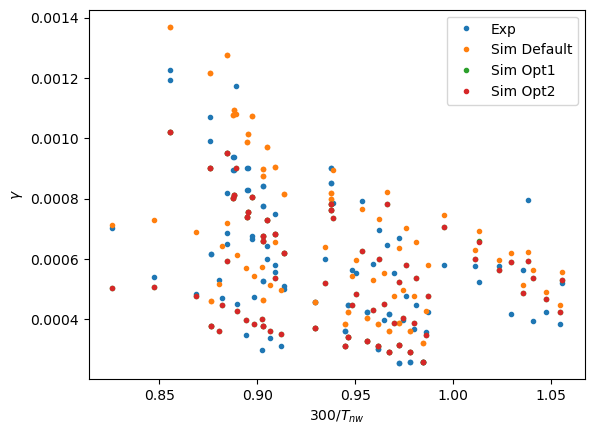

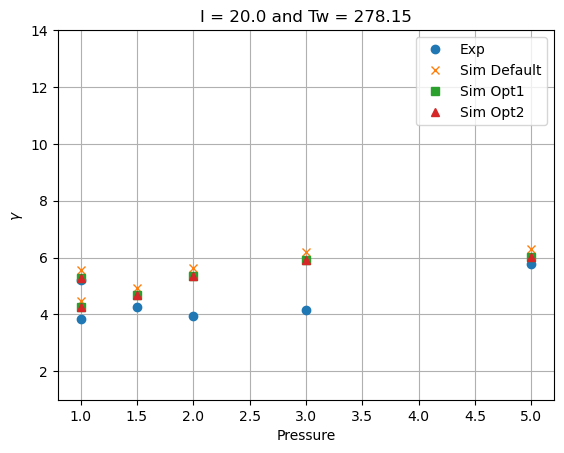

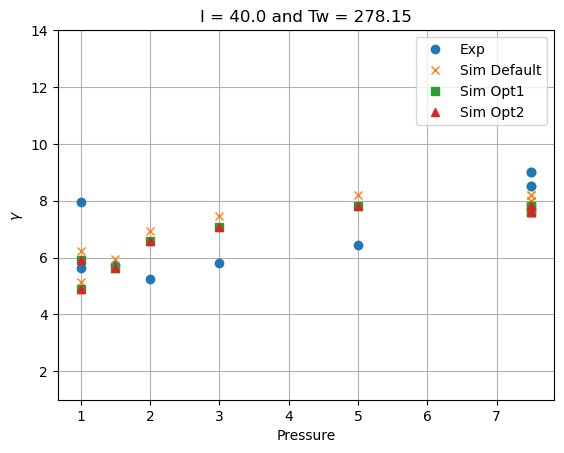

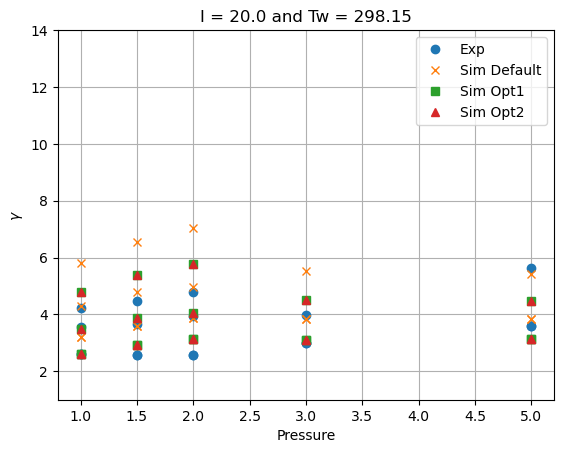

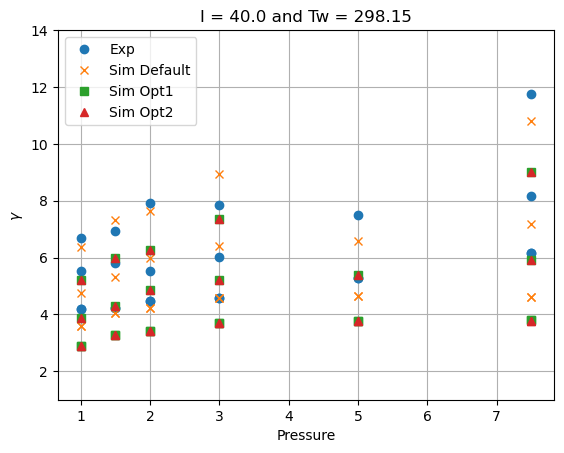

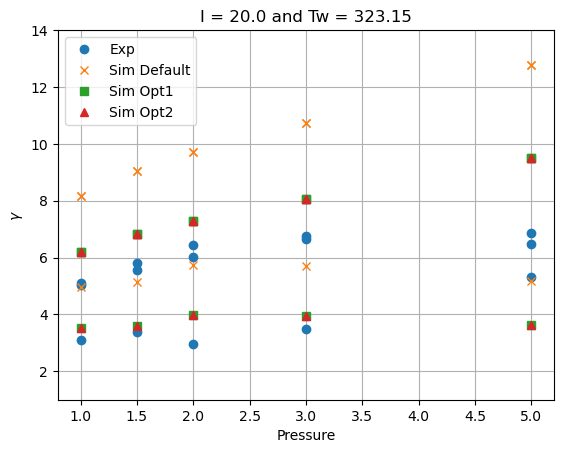

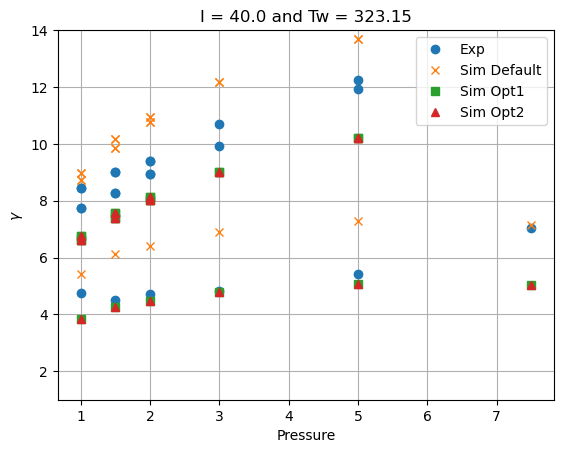

In [8]:


params_best2 = [4.941e-02, 4.885e-04, 1.725e+01,\
              5.406e-01, 5.815e-01,  1.930e+01]

loss_opt = optimizer_nu.objective_function(params_best2)
print(loss_opt)


params_best_mod = [4.941e-02, 4.885e-04, 1.725e+01,\
              4.941e-02, 4.885e-04, 1.725e+01]

loss_opt = optimizer_nu.objective_function(params_best_mod)
print(loss_opt)


params_base = [0.01634, 1.67e-4, 19.75]
loss_base = optimizer_base.objective_function(params_base)
print(loss_base)

do_plots((optimizer_base, params_base, "Sim Default"), (optimizer_nu, params_best_mod, "Sim Opt1"), (optimizer_nu, params_best2, "Sim Opt2"), "frequency_mod")


# 0.040738035610060924
# 0.04074487347495248

0.0385335395819385
0.11222424225336039
0.04073899090409117


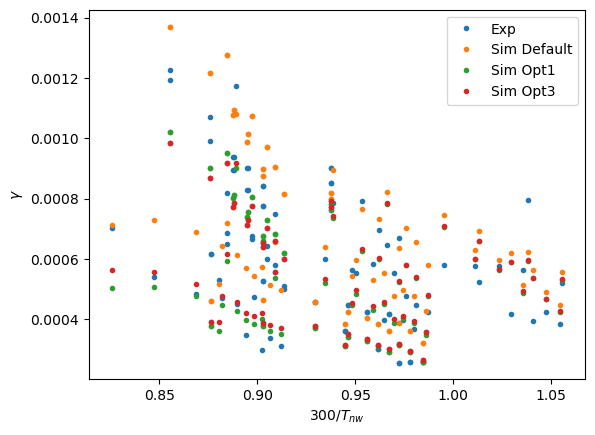

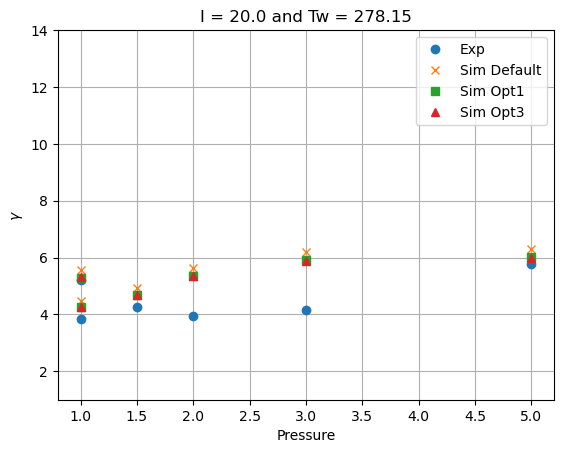

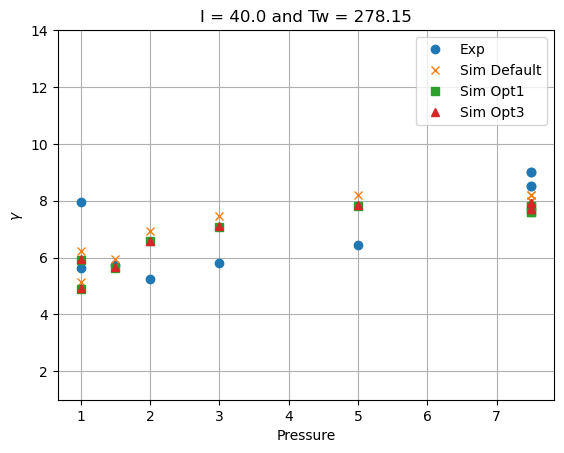

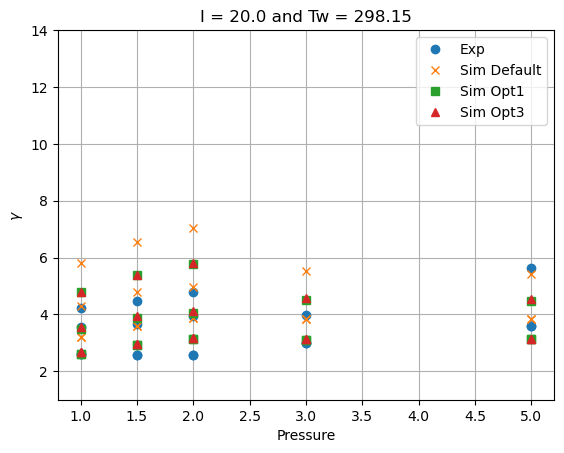

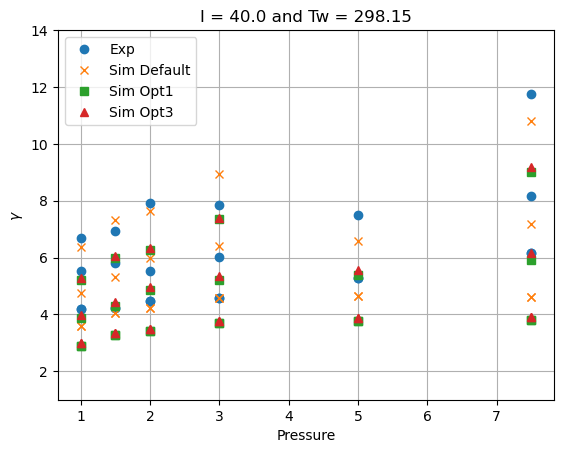

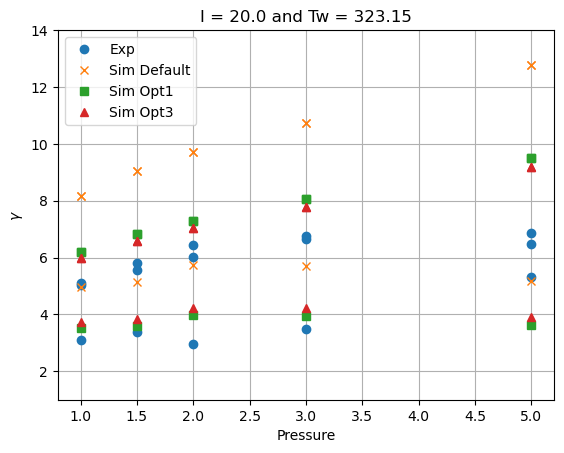

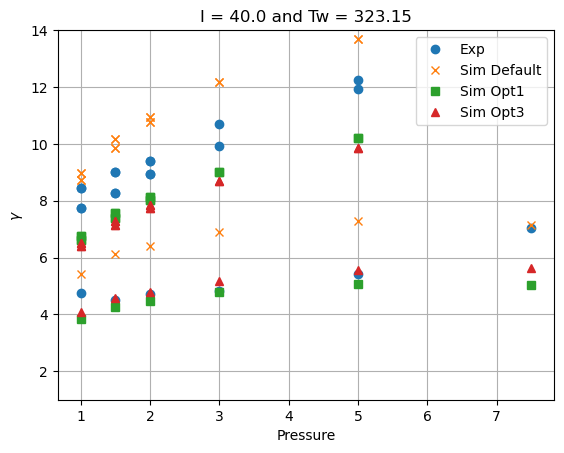

In [9]:
params_best = [
                1.941e-02, 4.534e-01, 5.602e-02, \
                4.320e-02, 5.783e-01, 5.507e-02, \
                5.595e-03, 1.983e-01]


loss_opt = optimizer_SF.objective_function(params_best)
print(loss_opt)


params_base = [0.01634, 1.67e-4, 19.75]
loss_base = optimizer_base.objective_function(params_base)
print(loss_base)



params_best_mod = [4.941e-02, 4.885e-04, 1.725e+01,\
              4.941e-02, 4.885e-04, 1.725e+01]

loss_opt = optimizer_nu.objective_function(params_best_mod)
print(loss_opt)

do_plots((optimizer_base, params_base, "Sim Default"), (optimizer_nu, params_best_mod, "Sim Opt1"), (optimizer_SF, params_best, "Sim Opt3"), "SF")

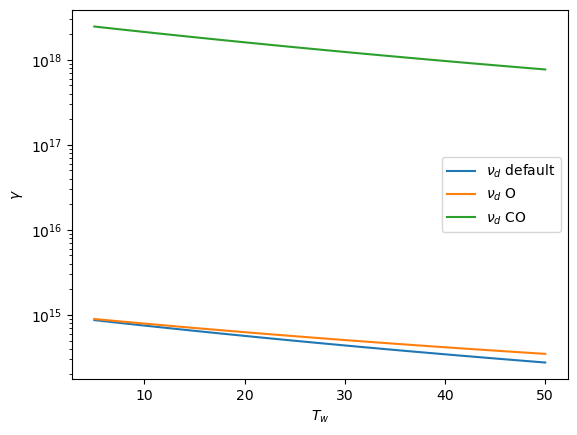

In [10]:

nu_d_func = lambda T, A, B, E: 1e15 * (A + B * np.exp(E/(const_dict['R'] * (T+273.15))))

Tspace = np.linspace(5, 50, 100)

freq_1 = nu_d_func(Tspace, 4.941e-02, 4.885e-04, 1.725e+01)
freq_2 = nu_d_func(Tspace, 5.406e-01, 5.815e-01, 1.930e+01)

freq_base = nu_d_func(Tspace, 0.01634, 1.67e-4, 19.75)


plt.figure()
plt.plot(Tspace, freq_base, label=r"$\nu_{d}$" + " default" )
plt.plot(Tspace, freq_1, label=r"$\nu_{d}$" + " O")
plt.plot(Tspace, freq_2, label=r"$\nu_{d}$" + " CO")
plt.yscale('log')
plt.xlabel(r"$T_{w}$")
plt.ylabel(r"$\gamma$")
plt.legend()
plt.savefig("figures/freq_mod_plots.png")




In [11]:
# do_plots((optimizer, params_best, "Sim Optimized 1"), (optimizer2, params_best2, "Sim Optimized 2"))